# Underwater positioning system
## using tensorflow

GPS does not work underwater. 
So for our underwater drone we need a system based on acoustic signals. 
The system consist of speaker, mounted on drone, and 3 microphones on buoys in known relative locations. 

Sending signal from the drone, we can record time passed before each buoy picks up the signal. 
Then we solve a system of quadratic equations using tensorflow, to determine the drone location.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [1]:
%tensorflow_version 1.x
import tensorflow as tf

TensorFlow 1.x selected.


In [3]:
SPEED_OF_SOUND_WATER = 1480 * 10**-3  # meters per millisecond
SPEED_OF_SOUND_WATER

1.48

In [0]:
def get_distance_to_bouy(rov_loc, bouy_loc):
    x_dist = rov_loc[0] - bouy_loc[0]
    y_dist = rov_loc[1] - bouy_loc[1]
    return (x_dist ** 2 + y_dist ** 2) ** 0.5

def generate_times_from_locations(rov_loc, bouys_locs, speed_of_sound):
    """ ROV_LOCATION: (x, y) BUOYS_LOCATIONS: {b1: (x, y), b2: (x, y), b3: (x, y)} SPEED_OF_SOUND: float
    returns: {b1: time_milliseconds, ...}
    """
    times = {}
    
    for bouy in bouys_locs:
        dist_to_bouy = get_distance_to_bouy(rov_loc, bouys_locs[bouy])
        time_to_bouy = dist_to_bouy / speed_of_sound
        times[bouy] = time_to_bouy
        
    return times
    

In [5]:
import random
# placing rover randomly within 100m radius from center
TEST_ROV_LOC = (random.randint(-10, 10), random.randint(-10, 10))  
TEST_BOUYS_LOCS = {'b1': (3, 4), 
                   'b2': (2, -3), 
                   'b3': (-1, 2)} 

LOCS = {
    'rov': TEST_ROV_LOC
}
LOCS.update(TEST_BOUYS_LOCS)

locs_df = pd.DataFrame.from_dict(LOCS, orient='index', columns=['x', 'y'])
locs_df

,x,y
rov,-9,-7
b1,3,4
b2,2,-3
b3,-1,2


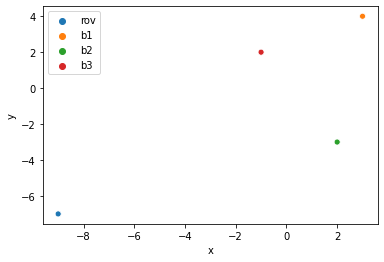

In [6]:
sns.scatterplot('x', 'y', data=locs_df, hue=locs_df.index)

In [7]:
times = generate_times_from_locations(TEST_ROV_LOC, TEST_BOUYS_LOCS, SPEED_OF_SOUND_WATER)
times

{'b1': 10.999203105472775, 'b2': 7.908581020756504, 'b3': 8.136212553238037}

In [0]:
def locate(buoys_locs, travel_times):
    """
    buoys_locs: [(x1, y1), (x2, y2), (x3, y3)],
    travel_times: [t1, t2, t3]    
    """
    
    buoys_x = [x for x, y in buoys_locs]
    buoys_y = [y for x, y in buoys_locs]
    distances = [t * SPEED_OF_SOUND_WATER for t in travel_times]
    
    # want to find those 
    x = tf.Variable([0], dtype=tf.float32)
    y = tf.Variable([0], dtype=tf.float32)

    # those are vectors fed up into the system
    X = tf.placeholder(tf.float32, [3, ])
    Y = tf.placeholder(tf.float32, [3, ])
    R = tf.placeholder(tf.float32, [3, ])

    cost = ((x - X) ** 2 + (y - Y) ** 2 - R ** 2) ** 2

    # opt = (x_1 - x_2) + (y_1 - y_2) + (x_1 - x_3) + (y_1 - y_3) + (x_2 - x_3) + (y_2 - y_3)

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    learning_rate = 0.001
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

    n_iter = 100
    # errors = []

    for i in range(n_iter):
        _, err = sess.run([optimizer, cost],
                {X: buoys_x,
                Y: buoys_y,
                R: distances})

        # errors.append(err)
        if sum(err) < 0.05:
            break

    x, y, = sess.run(
        [x, y], {
            X: buoys_x, 
            Y: buoys_y, 
            R: distances
        })
    return x, y

In [15]:
import random
# testing with added 10% noise
noisy_times = [t + (t * random.random() / 10 * random.choice([-1, 1])) for t in times.values()]
print(times, noisy_times)
x_pred, y_pred = locate(TEST_BOUYS_LOCS.values(), noisy_times)

{'b1': 10.999203105472775, 'b2': 7.908581020756504, 'b3': 8.136212553238037} [10.67145622582803, 7.955686072626187, 8.596352002424766]


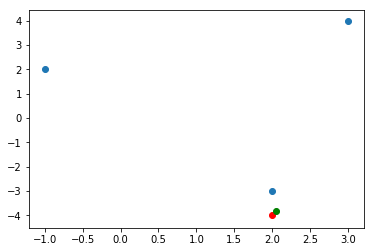

In [0]:
plt.scatter([x for x, _ in TEST_BOUYS_LOCS.values()], [y for _, y in TEST_BOUYS_LOCS.values()])
plt.scatter(TEST_ROV_LOC[0], TEST_ROV_LOC[1], color='red')
plt.scatter(x_pred, y_pred, color='green')